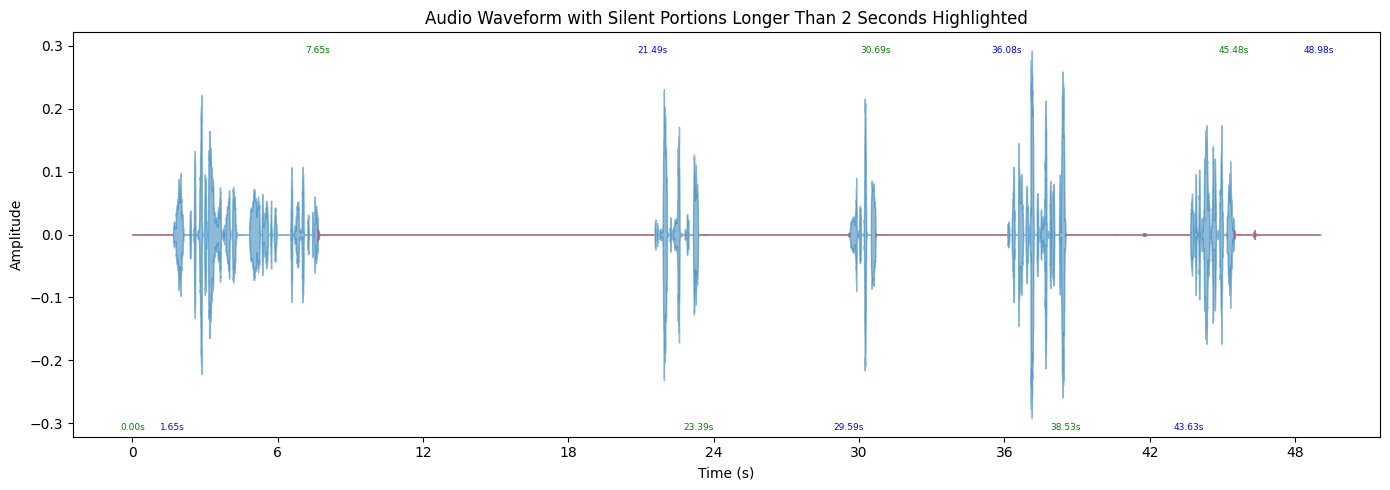

In [42]:

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# file_path = 'audio.wav'
file_path = 'call-audio.wav'
audio_data, sample_rate = librosa.load(file_path)

# Function to calculate short-time energy
def short_time_energy(signal, frame_size, hop_length):
    energy = np.array([
        np.sum(np.abs(signal[i:i + frame_size]**2))
        for i in range(0, len(signal) - frame_size, hop_length)
    ])
    return energy

# frame size hop length for calculation
frame_size = int(0.1 * sample_rate)  # Frame size of 100 ms
hop_length = frame_size // 2  # 50% overlap

# short-time energy
ste = short_time_energy(audio_data, frame_size, hop_length)

# Normalize short-time energy
normalized_ste = ste / np.max(ste)


threshold = 0.001  # silence definition
min_length_silence = 1  # min length of silence in seconds

# indices of frames below the threshold
quiet_frames = np.where(normalized_ste < threshold)[0]

# filter by duration
quiet_segments = []
start_index = None
for i in range(len(quiet_frames)):
    if start_index is None:
        start_index = quiet_frames[i]
    if i == len(quiet_frames) - 1 or quiet_frames[i + 1] != quiet_frames[i] + 1:
        end_index = quiet_frames[i]
        if (end_index - start_index) * hop_length / sample_rate >= min_length_silence:
            quiet_segments.append((start_index, end_index))
        start_index = None

# Plot waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_data, sr=sample_rate, alpha=0.5)

# Initialize the alternate positions for annotations
annotation_y_positions = [-0.3, .3]
pos_index = 0  #

# Define a smaller font size for the annotations
annotation_font_size = 6.5  # Decrease the font size as needed

# Highight and label silence positions
for start_index, end_index in quiet_segments:
    start_sample = start_index * hop_length
    end_sample = (end_index + 1) * hop_length
    if end_sample > len(audio_data):
        end_sample = len(audio_data)
    start_time = start_sample / sample_rate
    end_time = end_sample / sample_rate
    time_array = np.linspace(start_time, end_time, end_sample - start_sample)
    plt.fill_between(time_array,
                     [0]*(end_sample - start_sample),  # Fill from 0
                     audio_data[start_sample:end_sample],
                     color='red', alpha=0.3)

    # annotation position
    annotation_y_position = annotation_y_positions[pos_index]
    # start time
    plt.text(start_time, annotation_y_position, f"{start_time:.2f}s", fontsize=annotation_font_size, color='green', ha='center', va='top')
    # end time
    plt.text(end_time, annotation_y_position, f"{end_time:.2f}s", fontsize=annotation_font_size, color='blue', ha='center', va='top')

    # Alternate to avoid ovelap on spectogram
    pos_index = (pos_index + 1) % len(annotation_y_positions)

plt.title('Audio Waveform with Silent Portions Longer Than 2 Seconds Highlighted')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


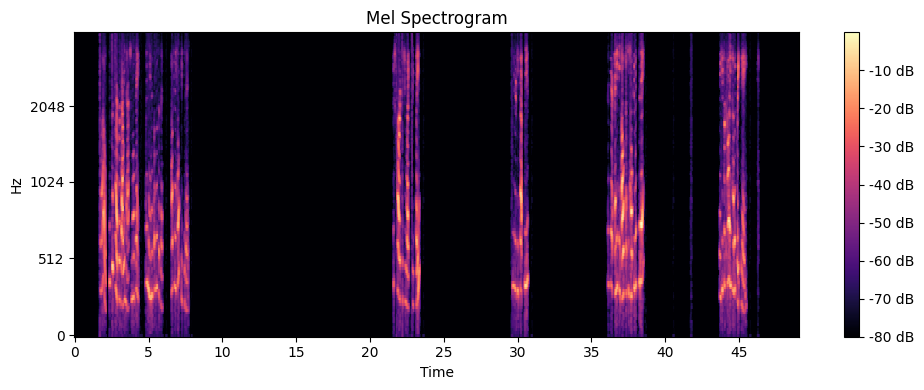

In [43]:
#------------Code From other Collab-----------------
#Last part is combining the code -- the spectrogram, and the graph with the silences

#Since charles did the spectrogram part and the graph with the silences we can use his graphs
#found a better way to calculate silences i explained it below instead of using a threshold

#code removes silences and reconstructs a new audio file



#audio file to download you can use any, this is the one i used
#also make sure you rename it to audio.wav
#https://drive.google.com/file/d/1lmCvPjfw9CWE6NaJapobRE2f_7xAmaSB/view?usp=sharing

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio file
audio_path = 'call-audio.wav'
# audio_path = 'audio.wav'
y, sr = librosa.load(audio_path, sr=None)
# Convert to a Mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# Convert to log scale (dB)
log_S = librosa.power_to_db(S, ref=np.max)


# Plotting the spectrogram

plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

In [44]:
#Labeling Silences on the Spectogram
import numpy as np

def short_term_energy(frame):
    """
    Calculate the short-term energy of an audio frame.
    :param frame: An array representing an audio frame.
    :return: The energy of the frame.
    """
    return sum([abs(x)**2 for x in frame]) / len(frame)

# Frame size for short-term energy calculation
frame_size = int(sr * 0.02)  # 0.02 seconds per frame

# Split the signal into frames
frames = [y[x:x+frame_size] for x in range(0, len(y), frame_size)]
energies = [short_term_energy(frame) for frame in frames]


In [45]:
silence_threshold = np.percentile(energies, 10)  # for example, the 10th percentile of energy


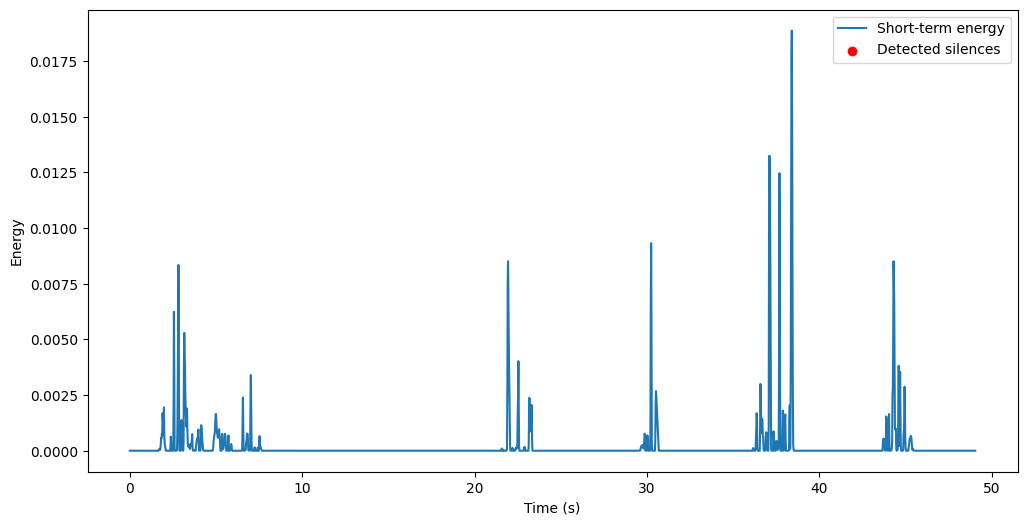

In [46]:
silent_frames = np.array(energies) < silence_threshold

silent_times = [i * frame_size / sr for i, val in enumerate(silent_frames) if val]


# Instantiate labels
labels = np.array([1 if frame else 0 for frame in silent_frames])


import matplotlib.pyplot as plt

times = [i * frame_size / sr for i in range(len(energies))]

plt.figure(figsize=(12, 6))
plt.plot(times, energies, label='Short-term energy')
plt.scatter(silent_times, [energies[int(t * sr / frame_size)] for t in silent_times], color='red', label='Detected silences')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.legend()
plt.show()


In [47]:
# Check frame length consistency
frame_lengths = [len(frame) for frame in frames]
if len(set(frame_lengths)) > 1:
    print("Frames have varying lengths. Consider padding or truncating.")

sequence_length = int(1 / 0.02)

# Flatten frames (if necessary) and prepare sequences for LSTM
X = []
y = []

for i in range(len(frames) - sequence_length):
    flat_frame = np.concatenate(frames[i:i+sequence_length]).flatten()  # Flatten the frame
    X.append(flat_frame)
    y.append(labels[i+sequence_length])

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM input - adjust the reshape logic based on the actual frame shape
X = X.reshape((X.shape[0], sequence_length, -1))  # -1 will automatically adjust the feature dimension



In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# LSTM model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, X.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 128)           147968    
                                                                 
 dropout_6 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 279681 (1.07 MB)
Trainable params: 279681 (1.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# Training the LSTM model
history = model.fit(X, y, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20
31/31 [==============================] - 13s 302ms/step - loss: 0.1500 - accuracy: 0.9912 - val_loss: 1.2804e-06 - val_accuracy: 1.0000
Epoch 2/20
31/31 [==============================] - 7s 218ms/step - loss: 3.2160e-06 - accuracy: 1.0000 - val_loss: 7.1385e-07 - val_accuracy: 1.0000
Epoch 3/20
31/31 [==============================] - 9s 276ms/step - loss: 2.6457e-06 - accuracy: 1.0000 - val_loss: 6.5122e-07 - val_accuracy: 1.0000
Epoch 4/20
31/31 [==============================] - 7s 218ms/step - loss: 2.3276e-06 - accuracy: 1.0000 - val_loss: 6.0721e-07 - val_accuracy: 1.0000
Epoch 5/20
31/31 [==============================] - 9s 277ms/step - loss: 2.1439e-06 - accuracy: 1.0000 - val_loss: 5.6466e-07 - val_accuracy: 1.0000
Epoch 6/20
31/31 [==============================] - 8s 250ms/step - loss: 1.9905e-06 - accuracy: 1.0000 - val_loss: 5.1605e-07 - val_accuracy: 1.0000
Epoch 7/20
31/31 [==============================] - 8s 247ms/step - loss: 1.9056e-06 - accuracy: 1.0000

In [50]:
# Evaluate the model
loss, accuracy = model.evaluate(X, y)
print(f"Loss: {loss}, Accuracy: {accuracy}")


76/76 [==============================] - 4s 55ms/step - loss: 3.0332e-07 - accuracy: 1.0000
Loss: 3.0331972311614663e-07, Accuracy: 1.0


In [51]:
# Predicting silences
predictions = model.predict(X)
predicted_silences = (predictions > 0.5).astype(int)

# Logic to remove silences from the audio signal
y_no_silence = []
for i, frame in enumerate(frames):
    if i >= sequence_length and predicted_silences[i-sequence_length][0] == 0:
        y_no_silence.extend(frame)

y_no_silence = np.array(y_no_silence)


76/76 [==============================] - 7s 78ms/step


In [52]:
import soundfile as sf

# Saving the reconstructed audio
# It will appear in files close files and open it again and it should come up
sf.write('after-call2.wav', y_no_silence, sr)


In [53]:
#Code Explanation - How we label Silences

'''
The silence threshold in the code is determined by the 10th percentile of the
energy values computed over 3-second windows.

This approach means that any 3-second window whose energy falls below the 10th
percentile of all such energies in the audio file is considered 'silent'.

# To elaborate:

1) Calculate Energy Over 3-Second Windows: The code calculates the short-term
energy of each 3-second window in the audio file.

2) Determine Silence Threshold: It then finds the 10th percentile of these
energy values. This percentile is used as a threshold - any window with an
energy below this threshold is considered 'silent'.

3) Labeling Frames: Each frame (of your original frame size, 0.02 seconds)
is then labeled based on whether it falls within a silent 3-second window.
If it does, it's labeled as silent (1); otherwise, it's labeled as non-silent (0).

4) The 10th percentile is a statistical measure that is used here to identify the
 lower 10% of energy values. By using this percentile, you are essentially
 marking the lowest energy 10% of the 3-second windows as silent.
 This threshold is a relative measure and depends on the specific energy
 distribution of your audio file.
'''
# How we built the model



"\nThe silence threshold in the code is determined by the 10th percentile of the\nenergy values computed over 3-second windows.\n\nThis approach means that any 3-second window whose energy falls below the 10th\npercentile of all such energies in the audio file is considered 'silent'.\n\n# To elaborate:\n\n1) Calculate Energy Over 3-Second Windows: The code calculates the short-term\nenergy of each 3-second window in the audio file.\n\n2) Determine Silence Threshold: It then finds the 10th percentile of these\nenergy values. This percentile is used as a threshold - any window with an\nenergy below this threshold is considered 'silent'.\n\n3) Labeling Frames: Each frame (of your original frame size, 0.02 seconds)\nis then labeled based on whether it falls within a silent 3-second window.\nIf it does, it's labeled as silent (1); otherwise, it's labeled as non-silent (0).\n\n4) The 10th percentile is a statistical measure that is used here to identify the\n lower 10% of energy values. By u